# Classification and Regression with a Neural Network in Pytorch

Welcome to your first programming assignment! 
In this assignment you will build your first classification and regression neural networks.
This assignment is a 'step-through' guide to implement a simple fully-connected neural network in Pytorch.

* In the first part of this exercise, you will implement a neural network with a 2 dimensional input. Your dataset is based on a two <a href=https://en.wikipedia.org/wiki/Crescent> crescent </a> moon-shaped groups for classification.

* Then, in the second part of this exercise, you will implement a regression model for predicting the output of a two dimensional function.

# Packages
Let's first import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [28]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import pdb
from tqdm import tqdm

# Dataset

In [29]:
id_num_str = input("Please Enter your Israeli ID?")
if (len(id_num_str) != 9):
    print('ID should contain 9 digits')
if (id_num_str.isdigit() is False):
    print('ID should contain only digits')
id_num = list(id_num_str[-3:])
random_num = sum(list(map(int, id_num)))
random_num

9

In [30]:
np.random.seed(random_num)
torch.manual_seed(random_num)
x, y = make_moons(500, noise=0.2, random_state = random_num)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_num)

**Visualize the dataset using matplotlib:**

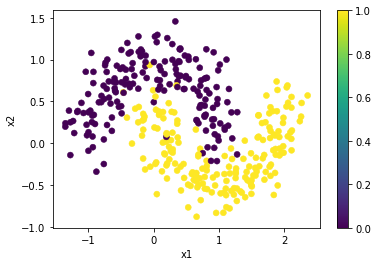

In [31]:
### START CODE HERE ###
#2 dimensional graph: purple points - class 0 , yellow points - class1
zline = y_train
xline = x_train[:,0]
yline = x_train[:,1]
plt.scatter(xline,yline,c=zline,cmap='viridis',linewidth=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()
# yellow points - class 1 , purple -0 

# Simple Logistic Regression

What you are required to do:

1. Implement a 2-class classification neural network with a zero hidden layer.
2. Plot loss vs epoch.
3. Plot AUC vs epoch for train and test sets. 
4. Plot ROC curve and calculate AUC for the test set.
5. Plot the learned decision boundary.
6. Briefly interpret graph's results.   

How you will do it:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Visualization.

In [32]:
### START CODE HERE ###
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

**Define the Model:**

In [61]:
class MlpArgs():
    def __init__(self, lr, num_epochs,probType):
        self.lr = lr
        self.num_epochs = num_epochs
        self.type = probType

#Logistic regression net that classifies to binary class
class MlpLogisticClassifier(nn.Module):
    def __init__(self, in_features):
        super(MlpLogisticClassifier, self).__init__()
        self.linear = nn.Linear(in_features, 1, bias=True)

    def forward(self, x):
        x = x.float()
        x = torch.sigmoid(self.linear(x))
        return x

# a generic function to calculate loss and auc on NN in case of classification problem and loss in case of regression problem
def infer(net, data: tuple, criterion): # data is tuple where index 0 is X and index 1 is Y
    net.eval()
    running_loss = 0
    auc = 0
    predictions = len(data[1])*[None]
    for i in range(len(data[0])): # get next data row
        x = data[0][i]
        y = data[1][i].float()
        with torch.no_grad(): 
            pred = net(x).float() #calculate prediction for data row
            predictions[i] = pred # save prediction in list of all the predictions
            loss = criterion(torch.tensor(pred.item()), y).item() # calculate prediction error for data row
        running_loss += loss # update total loss
    if args.type == 'regression':
        return running_loss / len(data[0]) # return mean loss in case of regression problem
    auc = roc_auc_score(data[1], predictions)
    return [running_loss / len(data[0]), auc] #return mean loss and auc in case of classification problen

# generic function using to train a NN and calculate losses and auc over train,validation and test set
def training_loop(
    args ,
    net,
    train: tuple,
    validation:tuple , # we will use test set also as validation set in order to calculate loss vs epoch
    test:tuple ,
    criterion_func=nn.BCELoss, # we will use Binary Cross Entropy for classification
    optimizer_func=torch.optim.SGD, # our optimizer is Stochastic gradient descent
):
    """The training runs here.
    args: a class instance of MlpArgs that contains the arguments
    net: the network we're training
    train, validation, test: dataloaders for the train, validation and test sets
    criterion: the loss function
    optimizer: the optimizer to be used"""
    criterion = criterion_func()
    optimizer = optimizer_func(net.parameters(), lr=args.lr)
    tr_loss, val_loss, auc_per_epoch, test_auc_per_epoch = [
        None] * args.num_epochs, [None] * args.num_epochs, [None] * args.num_epochs, [None] * args.num_epochs
    test_loss, untrained_test_loss = None, None
    predictions = len(train[1]) * [None]
    # Note that I moved the inferences to a function because it was too much code duplication to read.
    if test: # first calculating loss for test before training
        untrained_test_loss = infer(net, test, criterion)
    for epoch in range(args.num_epochs):
        net.train()
        running_tr_loss = 0
        for i in tqdm(range(len(train[0]))): # get next data row from training set
            x = train[0][i]
            y = train[1][i].float()
            optimizer.zero_grad()
            pred = net(x) # calculate current prediction for data row
            predictions[i] = pred # save prediction for auc calculation
            loss = criterion(pred, torch.tensor([y])) # calcluat loss 
            loss.backward()
            optimizer.step() # update gradients
            running_tr_loss += loss
        tr_loss[epoch] = running_tr_loss.item() / len(train[0]) # save training loss for epoch
        if args.type == 'classification': # calculate auc vs epoch in case of classification problem
            auc_per_epoch[epoch] = roc_auc_score(train[1], predictions)
        if validation: # calculate loss and auc for epoch on test set
            if args.type == 'classification':
                val_loss[epoch], test_auc_per_epoch[epoch] = infer(
                    net, validation, criterion)
            else:
                val_loss[epoch] = infer(net, validation, criterion)

    if test: # finally after finish training the net , calculate loss,auc and roc curve on test set
        test_loss = infer(net, test, criterion)
        if args.type == 'classification':
            with torch.no_grad():
                y_pred = net(test[0]).numpy()
            roc = roc_curve(test[1].numpy(), y_pred)
            test_fpr = roc[0]
            test_tpr = roc[1]

    print(f"Done training for {args.num_epochs} epochs.")
    # print(
    #    f"The BCELoss is {untrained_test_loss[0]:.2e} before training and {test_loss[0]:.2e} after training")
    if args.type == 'classification':
        print(
            f"The auc is {untrained_test_loss[1]:.2e} before training and {test_loss[1]:.2e} after training."
        )
    else:
        print(
        f"The MSELoss is {untrained_test_loss:.2e} before training and {test_loss:.2e} after training")
    print(
        f"The training and validation losses are "
        f"\n\t{tr_loss}, \n\t{val_loss}, \n\tover the training epochs, respectively."
    )
    if args.type == 'classification':
        print(
        f"The BCELoss is {untrained_test_loss[0]:.2e} before training and {test_loss[0]:.2e} after training")
        print(
            f"training auc by epochs "
            f"\n\t{auc_per_epoch} \n\tover the training epochs, respectively."
        )
        print(
            f"test auc by epochs "
            f"\n\t{test_auc_per_epoch} \n\tover the training epochs, respectively."
        )

    if args.type == 'classification':
        return tr_loss, val_loss, test_loss, untrained_test_loss, auc_per_epoch, test_auc_per_epoch, test_fpr, test_tpr
    return tr_loss, val_loss, test_loss, untrained_test_loss




**Training and validation:**

In [40]:
### START CODE HERE ###
in_features = x_train.shape[1] # get num of features
net = MlpLogisticClassifier(in_features)
args = MlpArgs(2e-2, 10,"classification") # lr,nom of epoches, classification problem(calculate auc)
trainXandYTuple = (x_train, y_train) # create train and test tuples
testXandYTuple = (x_test, y_test)
tr_loss, val_loss, test_loss, untrained_test_loss, auc_per_epoch, test_auc_per_epoch, test_fpr, test_tpr = training_loop(args,net,trainXandYTuple,testXandYTuple,testXandYTuple,nn.BCELoss) # train the model and get training and validation loses and roc_auc


100%|██████████| 375/375 [00:00<00:00, 1393.84it/s]
Done training for 10 epochs.
The auc is 2.17e-02 before training and 9.73e-01 after training.
The training and validation losses are 
	[0.6019439290364583, 0.43088399251302084, 0.3868284098307292, 0.36631807454427084, 0.35412890625, 0.3459996337890625, 0.34023787434895836, 0.33600504557291666, 0.3328204956054687, 0.33038409423828125], 
	[0.4361070320010185, 0.33814335843920706, 0.29804680341482165, 0.27565239107608797, 0.26106917196512225, 0.25071042624861, 0.24294015718251466, 0.23689116781204939, 0.2320537722185254, 0.22810532106086612], 
	over the training epochs, respectively.
The BCELoss is 9.18e-01 before training and 2.28e-01 after training
training auc by epochs 
	[0.7258643276186136, 0.9073873668622201, 0.9214273509141653, 0.9277780942074386, 0.9309961838582901, 0.9329042547132198, 0.9350401549239621, 0.9361508230335479, 0.9368627897704619, 0.9372899698126105] 
	over the training epochs, respectively.
test auc by epochs 
	[0.

**Visualizing the plots**:

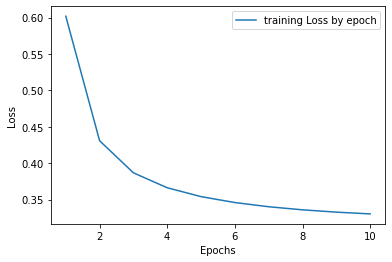

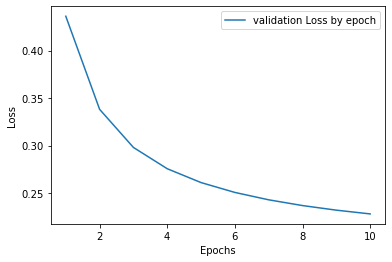

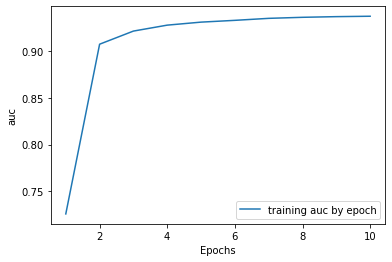

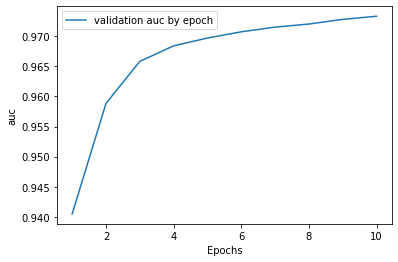

No handles with labels found to put in legend.


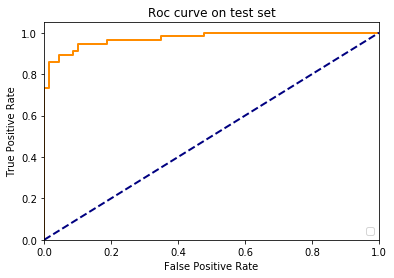

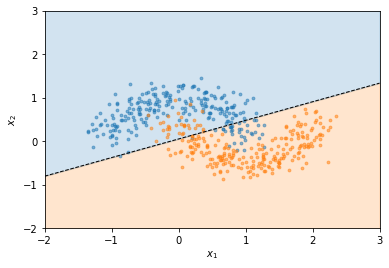

In [41]:

def plot_loss_graph(loss_list, train_or_val: str):
    loss_values = loss_list
    epochs = range(1, len(loss_values)+1)
    plt.plot(epochs, loss_values, label=f'{train_or_val} Loss by epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_auc_graph(auc, train_or_val: str):
    epochs = range(1, len(auc)+1)
    plt.plot(epochs, auc, label=f'{train_or_val} auc by epoch')
    plt.xlabel('Epochs')
    plt.ylabel('auc')
    plt.legend()
    plt.show()


def plot_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve on test set')
    plt.legend(loc="lower right")
    plt.show()

def plot_decision_boundary(bias, a1, a2, X, Y):
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.linear_model
    # Retrieve the model parameters.
    b = bias
    w1, w2 = a1, a2
    # Calculate the intercept and gradient of the decision boundary.
    c = -b/w2
    m = -w1/w2
    # Plot the data and the classification with the decision boundary.
    xmin, xmax = -2, 3
    ymin, ymax = -2, 3
    xd = np.array([xmin, xmax])
    yd = m*xd + c
    plt.plot(xd, yd, 'k', lw=1, ls='--')
    plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
    plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)
    plt.scatter(*X[Y == 0].T, s=8, alpha=0.5)
    plt.scatter(*X[Y == 1].T, s=8, alpha=0.5)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    plt.show()


    #create graphs
plot_loss_graph(tr_loss, "training") # training loss vs epoch
plot_loss_graph(val_loss, "validation") # test loss vs epoch
plot_auc_graph(auc_per_epoch, "training") # training auc vs epoch
plot_auc_graph(test_auc_per_epoch, "validation") # test auc vs epoch
plot_roc(test_fpr, test_tpr) #plot roc curve for test set
#get model paramters
par = []
for names, params in net.named_parameters():
    par.append(params)
bias = par[1].item() #bias
w1 = par[0][0][0].item() 
w2 = par[0][0][1].item()
plot_decision_boundary(bias, w1, w2, x, y) # plot desicion boundary



**Question:** 

Is the decision boundary linear or nonlinear in the case of a logistic regression? Explain.

**Answer:**

Type your answer here:



# Classification with Neural Networks

After you implemented "classical" logistic regression, now you will be implementing a neural network with one or more hidden layers.
You will need to choose the number of hidden layers and nodes in a feedforward neural network, activation function, the type of optimizer and its hyperparmeters which will give you the best result. Remember, we don't want to overfit the training data, we want to generalize the solution for new data not seen during training. 

Plot the same graphs as in the previous sections and explain the similarities and differences. 

**Define the Model:**

In [42]:
class MlpClassifierWithHidden(nn.Module):
    def __init__(self, in_features, hidden_size):
        super(MlpClassifierWithHidden, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.output(x))
        return x

**Training and validation:**

In [45]:
### START CODE HERE ###
hidden_size = 15
args = MlpArgs(2e-2, 50, 'classification')
net = MlpClassifierWithHidden(in_features, hidden_size)
tr_loss, val_loss, test_loss, untrained_test_loss, auc_per_epoch, test_auc_per_epoch, test_fpr, test_tpr = training_loop(args,net,trainXandYTuple,testXandYTuple,testXandYTuple,nn.BCELoss)
                                                                                                                         

100%|██████████| 375/375 [00:00<00:00, 1387.66it/s]
Done training for 50 epochs.
The auc is 2.63e-01 before training and 9.95e-01 after training.
The training and validation losses are 
	[0.5468583577473959, 0.38545926920572915, 0.34255546061197917, 0.32751121012369794, 0.3196839803059896, 0.3142160847981771, 0.30925821940104165, 0.3037109171549479, 0.2977085164388021, 0.29143721516927085, 0.2848040771484375, 0.2776991170247396, 0.27010150146484374, 0.2623443806966146, 0.2541225179036458, 0.24561891682942708, 0.2368997802734375, 0.22827419026692708, 0.22008538818359374, 0.21236134847005209, 0.20457631429036457, 0.19738346354166666, 0.19047049967447915, 0.18404905192057291, 0.17789713541666666, 0.17226572672526042, 0.16704369099934896, 0.16215411376953126, 0.15833674112955728, 0.15427713012695313, 0.15070193481445313, 0.14745229085286457, 0.14440918986002604, 0.14166444905598957, 0.1392062784830729, 0.1368461201985677, 0.13475547281901043, 0.13271309407552084, 0.13118861897786457, 0.129

**Visualizing the plots:**

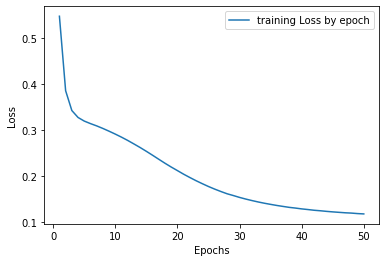

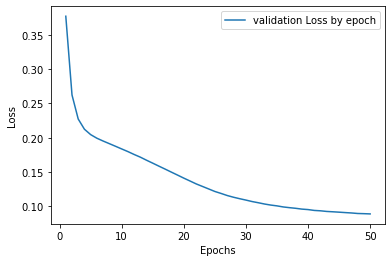

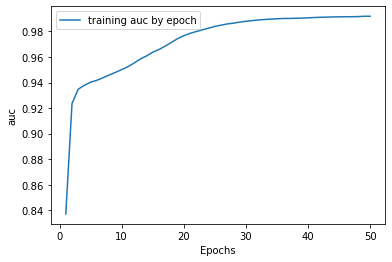

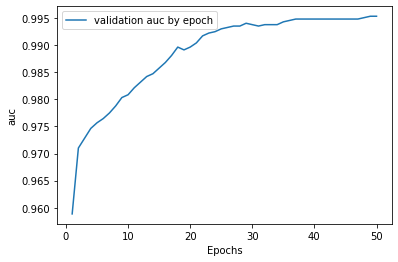

No handles with labels found to put in legend.


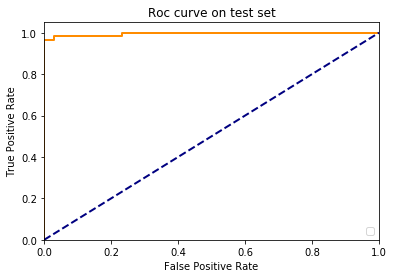

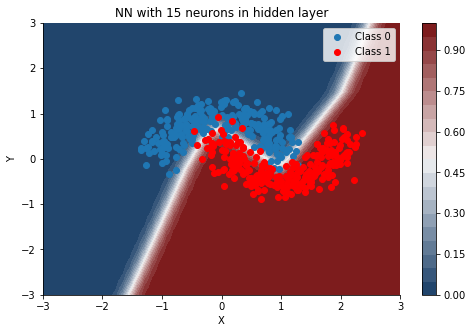

end!


In [47]:

def plot_decision_boundary_nonlinear(x, y, net, hidden_layers):
    import seaborn as sns
    z = np.linspace(-3, 3, 50)
    w = np.linspace(-3, 3, 40)
    mesh = np.meshgrid(z, w)
    a = np.zeros((2000, 2))
    a[:, 0] = np.ravel(mesh[0])
    a[:, 1] = np.ravel(mesh[1])
    contour_test = torch.Tensor(a)
    predict_out = net(contour_test)
    contour_plot = predict_out.detach().numpy()
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    fig, ax = plt.subplots(figsize=(8, 5))
    contour = ax.contourf(
        mesh[0], mesh[1], contour_plot.reshape(40, 50), 20, cmap=cmap)
    cbar = plt.colorbar(contour)
    ax.scatter(x[y == 0, 0], x[y == 0, 1], label='Class 0')
    ax.scatter(x[y == 1, 0], x[y == 1, 1], color='r', label='Class 1')
    sns.despine()
    ax.legend()
    ax.set(xlabel='X', ylabel='Y',
           title='NN with {} neurons in hidden layer'.format(hidden_layers))
    plt.show()


#create graphs
plot_loss_graph(tr_loss, "training") #training loss vs epoch
plot_loss_graph(val_loss, "validation") #test loss vs epoch
plot_auc_graph(auc_per_epoch, "training") # training auc vs epoch
plot_auc_graph(test_auc_per_epoch, "validation") #test auc vs epoch
plot_roc(test_fpr, test_tpr) # roc curve on test data
plot_decision_boundary_nonlinear(x, y, net, hidden_size) #non linear desicion boundary
print("end!")

# Regression with Neural Networks

In this part of the excercise you will need to implement a regression model using neural networks. The model should predict the output of a trigonometric function of two variables. Your data set is based on a meshgrid. Your task is to create a list of points that would correspond to a grid and use it for the input of your neural network. Then, build your neural networks and find the architecture which gives you the best results.
1. Plot the surface from the overall data and compare it to your predicted test sets.
2. Which loss function and validation metric did you choose?
3. Plot the loss and validation metrics vs epoch for the training and test sets.
4. Build a new neural network and try overfitting your training set. Show that you managed to overfit. Explain.

# Packages 

First import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm

**Generate data:**

In [50]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

**Define the Model:**

In [57]:
### START CODE HERE ###
class MlpRegression(nn.Module):
    def __init__(self, in_features, hidden_size, n_output):
        super(MlpRegression, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size*2))
        self.fc3 = nn.Linear(int(hidden_size*2), int(hidden_size*4))
        self.output = nn.Linear(int(hidden_size*4), n_output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x



**Training and validation:**

In [62]:
### START CODE HERE ###
def preproccess(x, y, z):
    x1, y1, z1 = np.ravel(x), np.ravel(y), np.ravel(z)
    s = (x1.shape[0], 2)
    t = np.zeros(s)
    for i in range(len(z)):
        t[i][0] = x1[i]
        t[i][1] = y1[i]
    X = t
    Y = z1
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preproccess(xx, yy, z)
trainXandYTuple = (x_train,y_train)
testXandYTuple = (x_test,y_test)
in_features = 2
hidden_size = 4
n_output = 1
net = MlpRegression(in_features, hidden_size, n_output)
args = MlpArgs(2e-3, 50,'regression')
tr_loss, val_loss, test_loss, untrained_test_loss = training_loop(args,net,trainXandYTuple,testXandYTuple,testXandYTuple,nn.MSELoss)

100%|██████████| 675/675 [00:01<00:00, 665.90it/s]
Done training for 50 epochs.


TypeError: 'float' object is not subscriptable

**Visualizing the plots:**

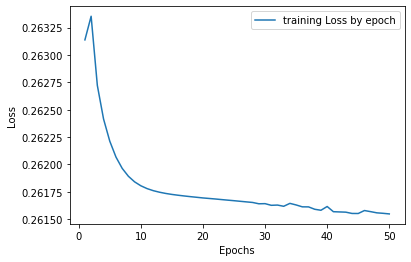

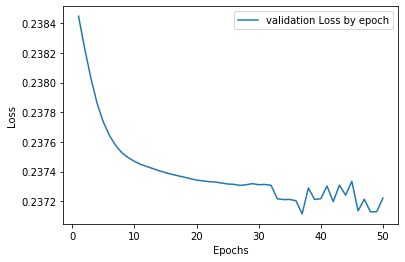

In [59]:
### START CODE HERE ###
plot_loss_graph(tr_loss, "training")
plot_loss_graph(val_loss, "validation")

### Build a new neural network and try overfitting your training set

**Generate data:**

In [ ]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

**Define the Model:**

In [ ]:
### START CODE HERE ###


**Training and validation:**

In [2]:
### START CODE HERE ###


**Visualizing the plots:**

In [ ]:
### START CODE HERE ###


5. Briefly explain graph's results.

Type your answer here:



6. How does your metric value differs between the training data and the test data and why?


Type your answer here:

